# 필터 시각화

이미지 필터 시각화란 학습된 신경망 모델에 이미지가 입력됐을 때

각 은닉 계층마다 인풋 이미지에 어떻게 반응하는지 시각적으로 확인하는 기법이다.

적용한 XAI기법이 어떤 인사이트를 주는지, 또 문제가 발생했을 때는 어떤 반응을 보이는지 시각적으로 확인해 볼 것이다.

학습 데이터로는 MNIST 데이터셋을 사용한다.

합성곱 신경망으로 학습을 하고, 학습한 모델의 은닉층을 분해해 이미지 필터를 시각화하기 좋은 형태로 구분할 것이다.

합성곱 신경망에 어떤 숫자 이미지를 입력했을 때 필터가 특징을 잘 분해하지 못한다면 

합성곱 신경망이 특정 이미지를 제대로 학습하지 못한 것으로 추론할 수 있을 것이다.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow.examples.tutorials.mnist import input_data

import warnings
warnings.filterwarnings(action='ignore')

In [3]:
# 메모리 할당 문제 해결
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

W1231 14:57:31.306898 139668667762496 deprecation.py:323] From <ipython-input-4-a839aeb82f4b>:1: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W1231 14:57:31.307813 139668667762496 deprecation.py:323] From /root/anaconda3/envs/xai/lib/python3.6/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.
W1231 14:57:31.308776 139668667762496 deprecation.py:323] From /root/anaconda3/envs/xai/lib/python3.6/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:262: extract_images (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, [None, 784], name="x-in")
true_y = tf.placeholder(tf.float32, [None, 10], name="y-in")
keep_prob = tf.placeholder('float')

x_image = tf.reshape(x, [-1,28,28,1])
hidden_1 = slim.conv2d(x_image, 5, [5,5])
pool_1 = slim.max_pool2d(hidden_1, [2,2])
hidden_2 = slim.conv2d(pool_1, 5, [5,5])
pool_2 = slim.max_pool2d(hidden_2, [2,2])
hidden_3 = slim.conv2d(pool_2, 20, [5,5])
hidden_3 = slim.dropout(hidden_3, keep_prob)
out_y = slim.fully_connected(slim.flatten(hidden_3),
                             10, activation_fn = tf.nn.softmax)

cross_entropy = -tf.reduce_sum(true_y * tf.log(out_y))
correct_prediction = tf.equal(tf.argmax(out_y,1), tf.argmax(true_y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

W1231 14:57:34.072138 139668667762496 deprecation.py:323] From /root/anaconda3/envs/xai/lib/python3.6/site-packages/tensorflow/contrib/layers/python/layers/layers.py:1634: flatten (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.flatten instead.


In [7]:
batchSize=50
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

for i in range(1000):
    batch = mnist.train.next_batch(batchSize)
    sess.run(train_step,
            feed_dict = {x:batch[0],true_y:batch[1], keep_prob:0.5})
    if i % 100 == 0 and i != 0:
        trainAccuracy = sess.run(accuracy,
                                feed_dict = {x:batch[0],true_y:batch[1], keep_prob:1.0})
        print("step %d, training accuracy %g"%(i, trainAccuracy))

step 100, training accuracy 0.52
step 200, training accuracy 0.7
step 300, training accuracy 0.82
step 400, training accuracy 0.8
step 500, training accuracy 0.84
step 600, training accuracy 0.86
step 700, training accuracy 0.84
step 800, training accuracy 0.82
step 900, training accuracy 0.86


In [8]:
testAccuracy = sess.run(accuracy,
                       feed_dict = {x:mnist.test.images,
                                   true_y: mnist.test.labels,
                                   keep_prob:1.0})
print("test accuracy %g"%(testAccuracy))

test accuracy 0.9094


이 모델을 얼마나 신뢰해야 하는지에 대한 질문에 대답은

학습 정확도, 테스트 정확도로 설명해야 한다.

그러나 이 모델은 정확도와 오류값으로는 설명하기 어려운 블랙박스이다.

(784,)
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


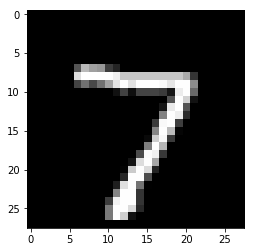

In [9]:
# 테스트 데이터 0번을 시각화하는 코드

index = 0
imageToUse = mnist.test.images[index]
imageLabel = mnist.test.labels[index]

print(imageToUse.shape)
print(imageLabel)
plt.imshow(np.reshape(imageToUse, [28,28]),
          interpolation = 'nearest', cmap='gray')

In [13]:
# 합성곱 신경망이 0번째 손글씨 이미지를 예측하는 코드

image_in = np.reshape(imageToUse, [1,784])
arg_max = tf.argmax(out_y,1)
predict = sess.run(arg_max,
                  feed_dict = {x : image_in, keep_prob:1.0})
print(imageLabel.argmax())
print(predict[0])
print(predict[0] == imageLabel.argmax())

7
7
True


(784,)
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


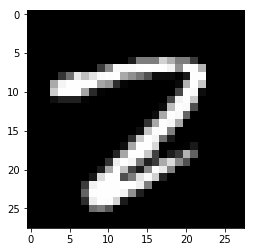

In [14]:
# 테스트 데이터 924번을 시각화하는 코드

index =924

imageToUse = mnist.test.images[index]
imageLabel = mnist.test.labels[index]

print(imageToUse.shape)
print(imageLabel)
plt.imshow(np.reshape(imageToUse, [28,28]),
          interpolation = 'nearest', cmap='gray')

In [15]:
image_in = np.reshape(imageToUse, [1,784])
arg_max = tf.argmax(out_y,1)
predict = sess.run(arg_max,
                  feed_dict = {x : image_in, keep_prob:1.0})
print(imageLabel.argmax())
print(predict[0])
print(predict[0] == imageLabel.argmax())

2
7
False


위 사례를 보면 2인 이미지를 7로 인식하는 오류가 발생한다.

이것을 보면 2를 그리는 마지막 획이 사선으로 이어지는 획과

너무 가까이 붙어 있어서 모델이 이것을 7로 착각했다고 볼 수도 있다.

In [16]:
# 합성곱 신경망이 테스트 데이터 924번을 어떻게 예측하는지 숫자별로 확률을 보여주는 코드

mat = sess.run(out_y, feed_dict={x: image_in, keep_prob:1.0})[0]

count = 0

for i in mat:
    print('[{}] {:.2%}'.format(count, i))
    count +=1

[0] 1.51%
[1] 0.04%
[2] 14.69%
[3] 1.77%
[4] 0.00%
[5] 2.23%
[6] 0.00%
[7] 62.17%
[8] 17.48%
[9] 0.13%


XAI는 결과를 설명하는 분야가 아니다.

결과가 속할 확률을 보여주는 것 이상으로 설명적이어야 한다.

이제 필터 시각화를 통해 은닉층을 시각화해본다.

In [23]:
# 은닉층 연산 결과를 시각화하는 코드

import math

def plotNNFilter(units):
    filters = units.shape[3]
    plt.figure(1, figsize = (20,20))
    n_columns = 5
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title("Filter" + str(i))
        plt.imshow(units[0,:,:,i], interpolation = 'nearest', cmap='gray')

In [24]:
# 이미지 하나가 특정 은닉층까지 통과한 결과물을 units 변수에 저장하고 호출하는 함수

def getActivations(layer, stimuli):
    units = sess.run(layer,
                    feed_dict = {x: np.reshape(stimuli,
                                              [1,784],
                                              order='F'),
                                keep_prob: 1.0})
    plotNNFilter(units)

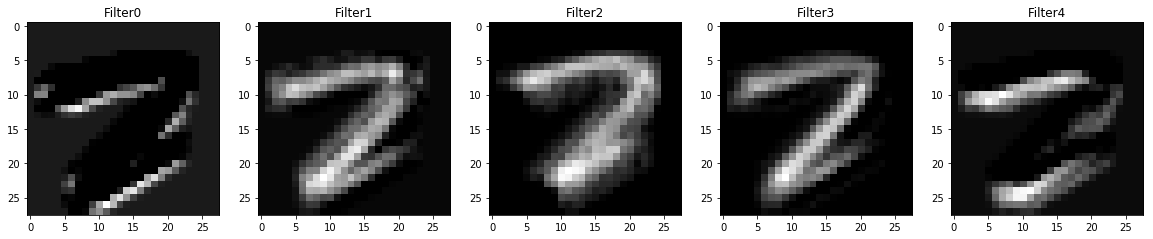

In [25]:
# 합성곱 신경망의 첫 번째 은닉층을 시각화하는 코드

getActivations(hidden_1, imageToUse)

손글씨 2가 신경망에 입력됐을 때 첫 번째 은닉층 통과 결과를 시각화했다.

첫 번째 필터는 다섯 개이므로 총 다섯 개의 필터가 시각화된다.

위 결과, 합성곱 필터는 입력된 이미지의 선 요소를 강화하거나 이중화하거나 흐릿하게 하는 등의 처리로

원본 이미지로부터 정보를 추출했다.

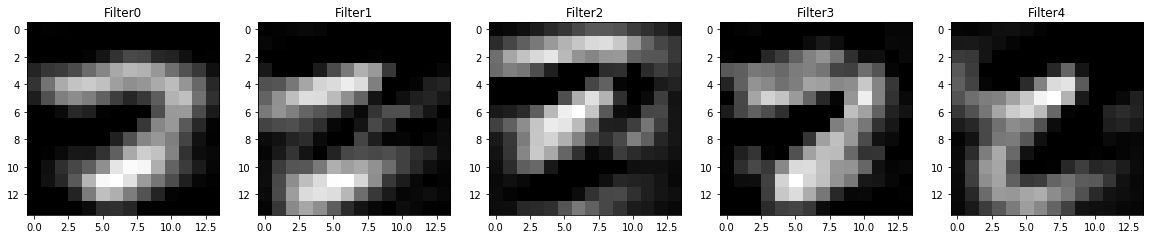

In [26]:
# 합성곱 신경망의 두 번째 은닉층을 시각화하는 코드

getActivations(hidden_2, imageToUse)

두 번째 은닉층은 첫 번째 은닉층의 합성곱 연산 이후에 2X2 풀링 연산까지 수행한다.

따라서 이미지 크기는 첫 번째 합성곱 연산 이후에 반으로 줄어들 것이다(28X28 -> 14X14).

첫 번째 은닉층과 비교했을 때 훨씬 더 추상적이다. 

두 번째 합성곱 연산이 끝난 필터는 이미지가 한쪽으로 쏠려 있거나 훨씬 더 흐릿해졌다.

**이미지가 흰색에 가까울수록 합성곱 신경망 요소가 활성화(activated)됐다는 의미이므로** 

**합성곱 필터 시각화 결과가 밝다면 블랙박스가 해당 필터를 주시하고 있다고 해석할 수 있다.**

즉, 합성곱 신경망은 입력한 손글씨 숫자 2에 대해서 상단부터 사선으로 이어지는 요소를 중점으로 파악하고 숫자 2를 분류한다.

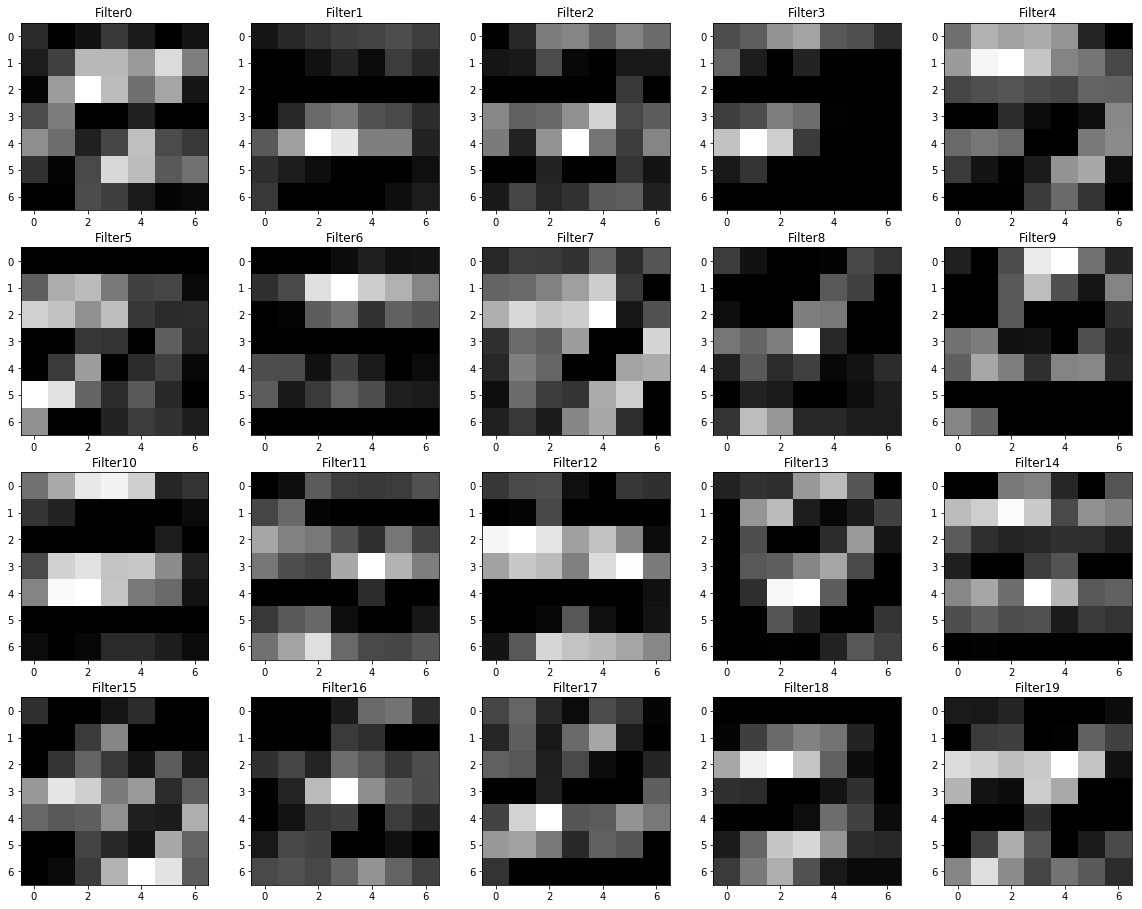

In [27]:
# 합성곱 신경망의 세 번째 은닉층을 시각화하는 코드

getActivations(hidden_3, imageToUse)

첫 번째와 두 번째 은닉층 합성곱 결과와 비교했을 때 훨씬 더 추상적이다.

합성곱 신경망은 위 그림처럼 추상적인 데이터를 종합해서 이미지를 예측한다.

이제 진짜 손글씨 7을 신경망에 입력하고 숫자 2의 은닉층 필터와 얼마나 유사한지 비교해본다.

In [29]:
imageToUse = mnist.test.images[223]

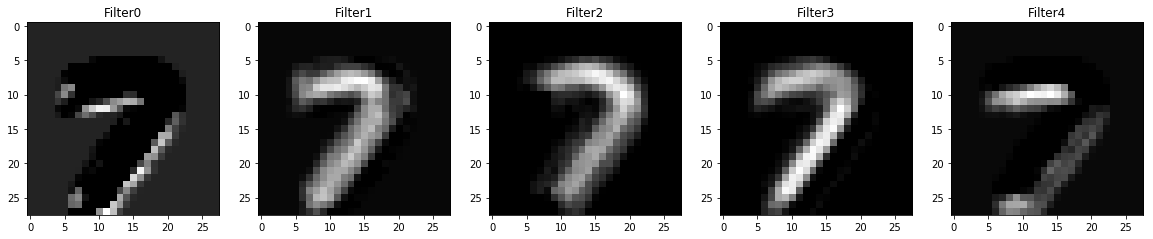

In [30]:
getActivations(hidden_1, imageToUse)

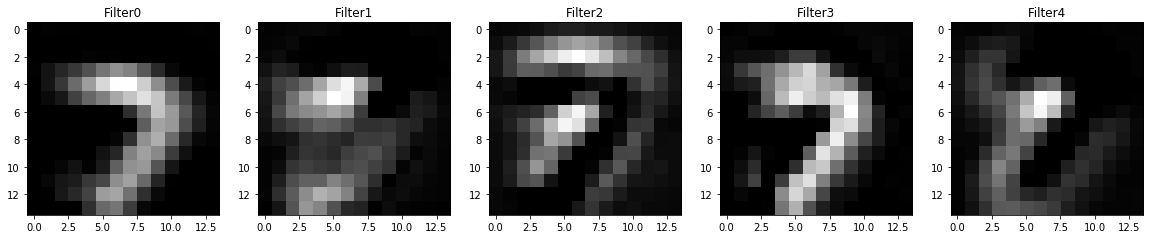

In [31]:
getActivations(hidden_2, imageToUse)

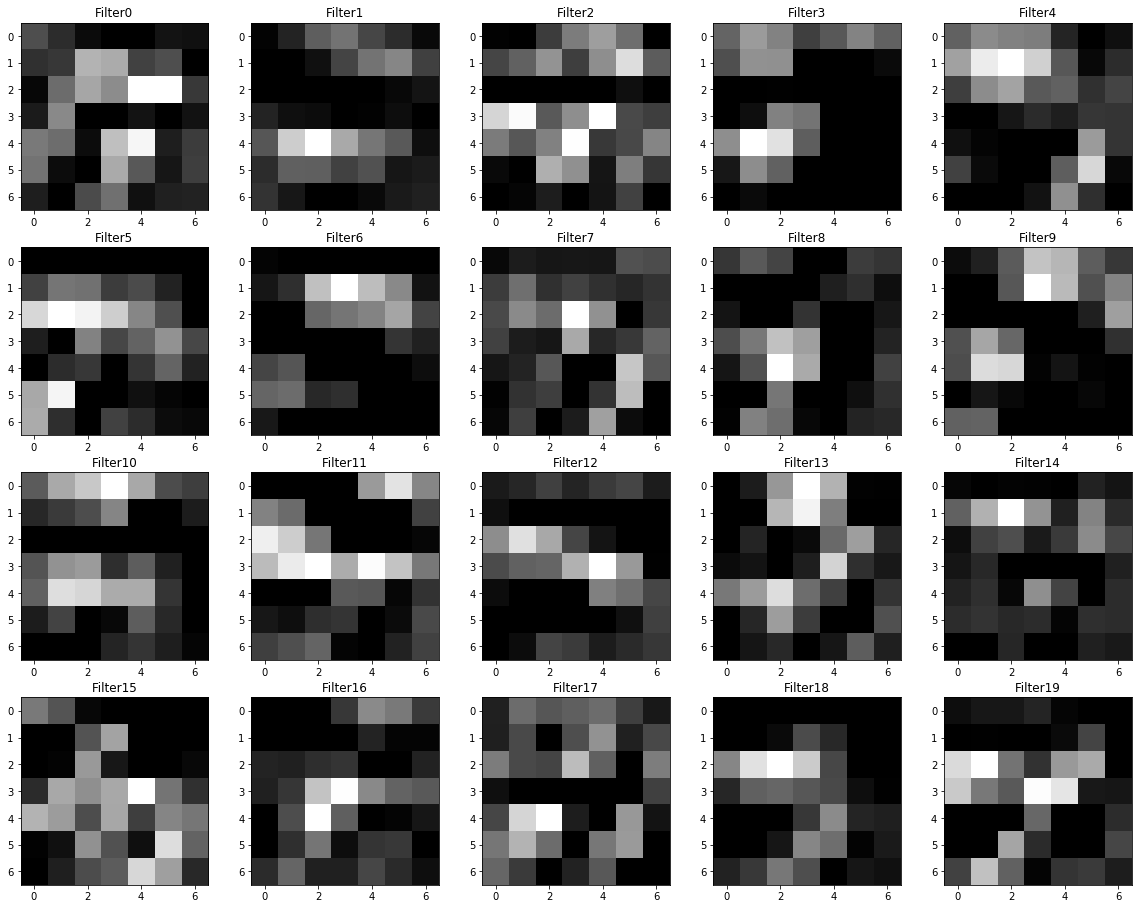

In [32]:
getActivations(hidden_3, imageToUse)

두 번째 은닉층 출력 결과를 비교했을 때, 숫자 2와 숫자 7을 구분하기 위해

반드시 필요한 마지막 획 성분이 빠져있다.

또한, 육안으로 확인해봐도 두 은닉층 차이를 구별할 수가 없다.
<br><br><br>
이 모델을 개선하기 위해 다음과 같은 솔루션을 제안할 수 있을 것이다.

1. 손글씨 2의 꼬리획 특징을 분리할 수 있는 필터를 추가한다.

2. 손글씨 2와 손글씨 7 데이터를 키워 모델이 두 이미지를 확실하게 구분할 수 있게 한다.

이 두 가지 제안(특히 1번)은 필터 시각화 없이는 발견할 수 없는 개선점이다.

필터 시각화가 불가능하다면 합성곱 신경망이 어느 부분을 중점적으로 바라보고 있는지 확인하기 어려울 것이다.

또한, 모델을 개선할 때도 어떤 데이터와 구조를 보강해야 하는지 판단하기 어렵다.

<br><br>

필터 시각화 이후에 

역합성곱(Deconvolution)

역전파(Backpropagation), 가이드 역전파(Guided Backpropagation),

최대 활성함수(Activation Maximization)

등으로 갈라졌다.

이 기법들은 활성화 함수에 경사도를 변형해서 시각화를 시도하거나 필터가 가장 잘 반응하는

대표 이미지를 만드는 등의 방식으로 블랙박스를 관찰한다.

<br><br>

필터 시각화는 데이터 과학자 및 의사 결정권자가 모델을 어떻게 인식하는지 해석하는 데 근거가 되는 자료다.

필터 시각화를 적극 활용하면 모델의 인식 방향을 관찰하고 모델을 개선할 수 있다.

필터 시각화의 단점으로는 

1. 은닉층을 비가시적인 형태로 조작할 수가 없다. 이미지를 반드시 2차원 행렬로 고정해야 한다는 점이다.

2. 해석자에 따라서 관점이 다를 수 있다. 해당 이미지를 받고 해석하는 일에는 주관이 개입할 소지가 있다. 

따라서 필터 시각화 기법을 사용할 때는 모델의 해석 능력과 분류 정확도가 함께 성장하기 어렵다는 사실을 인지하고 있어야 한다.

그럼에도 불구하고 필터 시각화는 구현이 간편하고, 이해하기 쉬우며, 

개선점을 찾기 쉽기 때문에 가장 쉽게 추천하는 딥러닝 기반 이미지 분류 XAI 기법이다.